In [1]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import dataframe_image as dfi

import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import matplotlib.cm 
import matplotlib.colors 
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, fasta_file_parser_gtdb, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.gene import Gene, Genome
from selenobot.organism import Organism

from dataset import Dataset 

%load_ext autoreload 
%autoreload 2


In [26]:
species = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 

# Using the genomes from the GTDB species representative for release r207.
genome_ids = dict() 
genome_ids['Pseudomonas aeruginosa'] = 'GCF_001457615.1'
genome_ids['Bacillus subtilis'] = 'GCF_000009045.1'
genome_ids['Escherichia coli'] = 'GCF_000195955.2'
genome_ids['Mycobacterium tuberculosis'] = 'GCF_003697165.2'
genome_ids['Aliivibrio fischeri'] = 'GCF_016464335.1'

# genome_metadata_df = pd.read_csv('../data/gtdb_genome_metadata_bacteria.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(species)]
# genome_metadata_df[['species', 'genome_size', 'gc_percentage']]

label_map = {'cds':'cds', 'error':'error', 'inter':'error (intergenic)', 'pseudo':'pseudogene', 'rna':'other', 'misc':'other'}
color_map = {'cds':'tab:green', 'error':'tab:red', 'error (intergenic)':'tab:red', 'pseudogene':'tab:blue', 'other':'gray'}
labels = list(label_map.values())

feature_types = ['plm_esm_gap', 'plm_pt5']

In [ ]:
if (not os.path.exists('../data/model_organisms/organisms.pkl')):
    organisms = list()
    for species in genome_ids.keys():
        print(f'\n{species}')
        organism = Organism(genome_ids[species], species)
        organism.label()
        organisms.append(organism)
    with open('../data/model_organisms/organisms.pkl', 'wb') as f:
        pickle.dump(organisms, f)
else:
    with open('../data/model_organisms/organisms.pkl', 'rb') as f:
        organisms = pickle.load(f)

In [ ]:


def table_1(path='../data/model_organisms/table_01.png'):   
    table_df = list()
    for organism in organisms:
        row = dict()
        row['species'] = organism.species
        row['GC content'] = organism.species
        row['ref. genome size'] = organism.size(source='ncbi', pseudo=False)
        row['GTDB genome size'] = organism.size(source='gtdb')
        row['num. pseudogenes'] = organism.size(source='ncbi', pseudo=True)
        row['perc. exact matches'] = f'{100 * len(organism.to_df(label='match')) / organism.size(source='gtdb'):.2f}%'
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('species')
    dfi.export(table_df, path)


def table_2(path='../model_organisms/table_02.png'):
    table_df = list()
    for organism in organisms:
        row = dict()
        row['species'] = organism.species
        row['GC content'] = organism.species
        row['ref. genome size'] = organism.size(source='ncbi', pseudo=False)
        row['GTDB genome size'] = organism.size(source='gtdb')
        row['num. pseudogenes'] = organism.size(source='ncbi', pseudo=True)
        row['perc. exact matches'] = f'{100 * len(organism.to_df(label='match')) / organism.size(source='gtdb'):.2f}%'
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('species')
    dfi.export(table_df, path)

make_summary_table()

In [152]:
def load_predictions():
    pred_df = list()
    for organism in organisms:
        df = pd.read_csv(f'../data/results/gtdb_{organism.code_name}.predict.csv', index_col=0)
        df = df[[col for col in df.columns if 'prediction' in col]]
        df = df.merge(organism.to_df(max_seq_length=1000), left_index=True, right_index=True, how='inner')
        pred_df.append(df)
    pred_df = pd.concat(pred_df)
    pred_df.label = pred_df.label.replace(label_map)
    return pred_df

pred_df = load_predictions()
pred_sec_df = pred_df[pred_df.binary_model_plm_esm_gap_prediction == 1]

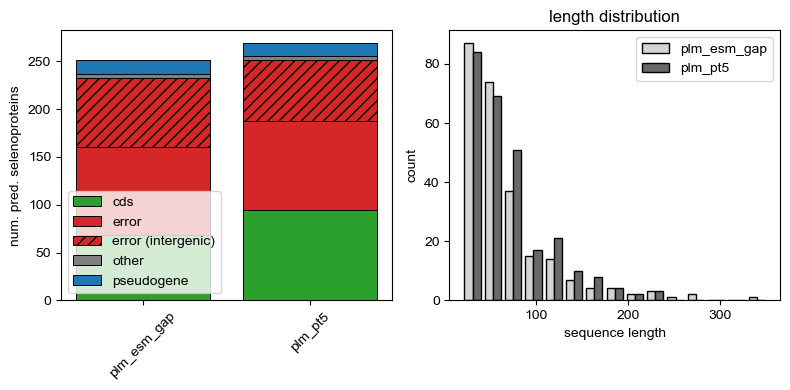

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax = axes[0]
bottom = np.zeros(len(feature_types))
positions = np.arange(len(feature_types))

legend = []
for label, label_df in pred_df.groupby('label'):
    heights = [(label_df[f'binary_model_{feature_type}_prediction'] == 1).sum() for feature_type in feature_types]
    ax.bar(positions, heights, bottom=bottom, color=color_map[label], hatch='///' if (label == 'error (intergenic)') else None, edgecolor='black', lw=0.7)
    bottom += np.array(heights)
    legend += [label]

ax.set_xticks(positions, labels=feature_types, ha='center', rotation=45)
ax.set_ylabel('num. pred. selenoproteins')
ax.legend(legend)

ax = axes[1]
hist = []
for feature_type in feature_types:
    lengths = pred_df[pred_df[f'binary_model_{feature_type}_prediction'] == 1].seq.apply(len)
    hist.append(lengths)
    
ax.hist(hist, bins=15, color=['lightgrey', 'dimgray'], edgecolor='black', lw=0.5)
ax.legend(feature_types)
ax.set_ylabel('count')
ax.set_xlabel('sequence length')
ax.set_title('length distribution')

plt.tight_layout()
plt.show()

In [51]:
def gtdb_organisms_to_df(labels:list):
    df = list()
    for label in labels:
        df.append(pd.concat([organism.to_df() for organism in organisms]))
    df = pd.concat(df)
    df.label = df.label.replace(label_map)
    df = df[df.label.isin(labels)]
    return df

def ncbi_organisms_to_df():
    df = list()
    for organism in organisms:
        df.append(FASTAFile(organism.ncbi_proteins_path).to_df())
    df = pd.concat(df)
    df.label = 'cds'
    return df

In [120]:
shared_df.ref_seq.apply(len).max()

np.int64(5488)

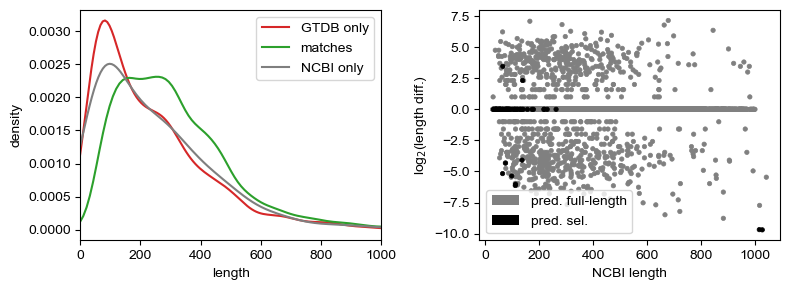

In [151]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

ax = axes[0]

gtdb_df = gtdb_organisms_to_df(labels=['error', 'error (intergenic)', 'pseudogene', 'other'])
shared_df = pd.concat([organism.to_df(label='cds') for organism in organisms])
ncbi_df = ncbi_organisms_to_df()
ncbi_df = ncbi_df[~ncbi_df.index.isin(shared_df.protein_id)]

gtdb_df.seq.apply(len).plot.kde(ax=ax, color='tab:red')
shared_df.ref_seq.apply(len).plot.kde(ax=ax, color='tab:green')
ncbi_df.seq.apply(len).plot.kde(ax=ax, color='tab:gray')
ax.set_xlim(0, 1000)
ax.set_ylabel('density')
ax.set_xlabel('length')
ax.legend(['GTDB only', 'matches', 'NCBI only'])

ax = axes[1]


shared_df = shared_df.merge(pred_df, left_index=True, right_index=True, how='inner')
shared_df = shared_df.sort_values('binary_model_plm_esm_gap_prediction')
# colors = []
# for row in shared_df.itertuples():
#     if row.same_start and row.same_stop:
#         colors += ['tab:blue']
#     elif row.same_start and (row.strand == 1):
#         colors += ['tab:green']
#     elif row.same_start and (row.strand == -1):
#         colors += ['tab:red']
#     elif row.same_stop and (row.strand == -1):
#         colors += ['tab:green']
#     elif row.same_stop and (row.strand == 1):
#         colors += ['tab:red']


# diffs = np.sign(shared_df.length_diff) * np.log(np.abs(shared_df.length_diff // 3) + 1)
# diffs = shared_df.length_diff // 3
# shared_df = shared_df[shared_df.length_diff != 0]
diffs = [0 if (d == 0) else np.sign(d) * np.log2(abs(d)) for d in shared_df.length_diff // 3]
lengths = np.log10(shared_df.ref_seq.apply(len))
lengths = shared_df.ref_seq.apply(len) 

ax.scatter(lengths, diffs, c=shared_df.binary_model_plm_esm_gap_prediction.replace({1:'black', 0:'gray'}), lw=0.5, s=10) 
ax.set_ylabel('log$_{2}$(length diff.)')
ax.set_xlabel('NCBI length')
ax.legend(handles=[Patch(facecolor='gray'), Patch(facecolor='black')], labels=['pred. full-length', 'pred. sel.'])
# ax.set_ylim(-1500, 500)

plt.tight_layout()
plt.show()



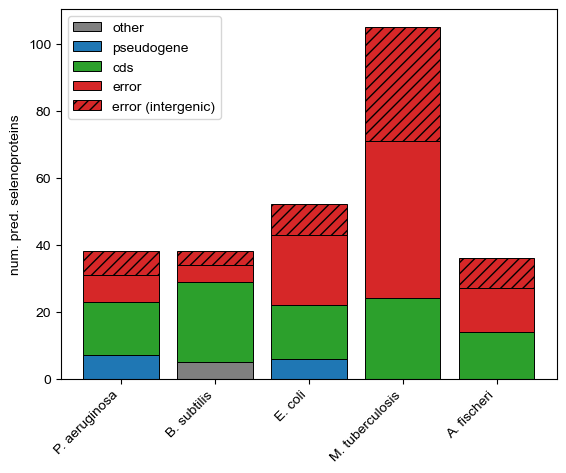

In [149]:
fig, ax = plt.subplots()

species = list(genome_ids.keys()) 

bottom = np.zeros(len(species))
for label in ['other', 'pseudogene', 'cds', 'error', 'error (intergenic)']:
    label_df = pred_df[(pred_df.label == label) & (pred_df.binary_model_plm_pt5_prediction == 1)]
    # label_df = pd.concat([organism.to_df(label=label) for organism in organisms])
    heights = np.array([(label_df.species == s).sum() for s in species])
    ax.bar(np.arange(len(organisms)), heights, bottom=bottom, color=color_map[label], edgecolor='black', linewidth=0.7, hatch='///' if (label == 'error (intergenic)') else None)
    bottom += heights

ax.set_xticks(np.arange(len(organisms)), labels=[f'{organism.species.split()[0][0]}. {organism.species.split()[-1]}' for organism in organisms], rotation=45, ha='right')
ax.legend(['other', 'pseudogene', 'cds', 'error', 'error (intergenic)'])
# ax.set_yscale('log')
ax.set_ylabel('num. pred. selenoproteins')
plt.show()



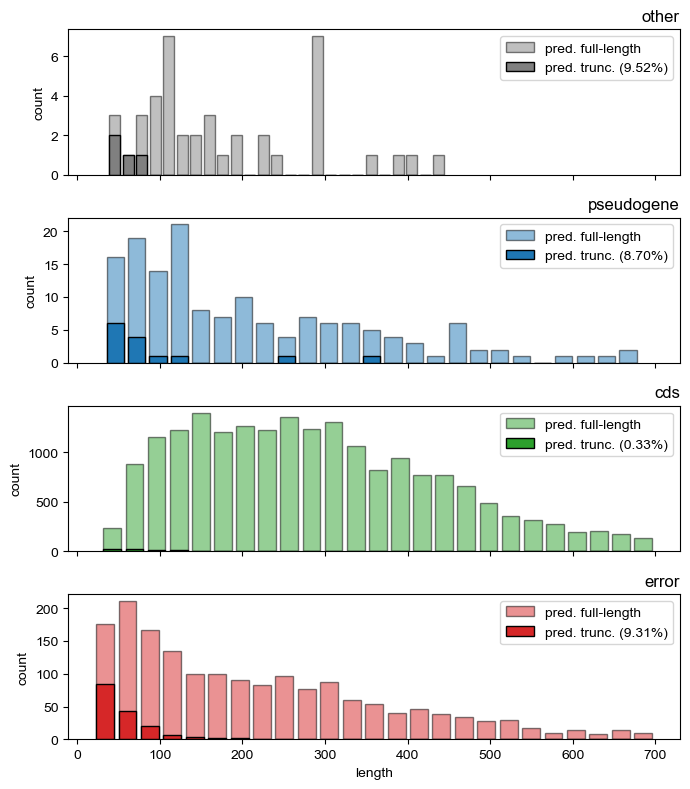

In [162]:
fig, axes = plt.subplots(nrows=4, figsize=(7, 8), sharex=True)

def figure_4(pred_df:pd.DataFrame, max_seq_length:int=700, axes:list=None):

    pred_df.label = pred_df.label.replace({'error (intergenic)':'error'})
    pred_sec_df = pred_df[pred_df.binary_model_plm_esm_gap_prediction == 1]

    for ax, label in zip(axes, ['other', 'pseudogene', 'cds', 'error']):
        lengths = pred_df[pred_df.label == label].seq.apply(len)
        _, bin_edges, _, = ax.hist(lengths[lengths < max_seq_length], color=color_map[label], bins=25, rwidth=0.8, edgecolor='black', alpha=0.5)
        p = f'{100 * len(pred_sec_df[pred_sec_df.label == label]) / len(lengths):.2f}%'

        lengths = pred_sec_df[pred_sec_df.label == label].seq.apply(len) # Look only at the lengths of the predicted selenoproteins. 
        ax.hist(lengths[lengths < max_seq_length], color=color_map[label], bins=bin_edges, rwidth=0.8, edgecolor='black')

        ax.set_ylabel('count')
        ax.set_title(label, loc='right')
        ax.legend(['pred. full-length', f'pred. trunc. ({p})'])

    ax.set_xlabel('length')

figure_4(pred_df, axes=axes)

plt.tight_layout()
plt.show()

# I am really curious as to why so many of the short peptides are tagged as full-length... what characteristics of the
# false positives make them false positives, other than length? It seems as though the error sequences are slightly 
# more prone to this problem, though I wonder how much of this effect is due to the fact that the error sequences tend 
# to be shorter. 

In [10]:
def load_embeddings(label:str, feature_type:str='plm_esm'):
    '''Load in the PLM embeddings which correspond to sequences with a specific label.'''
    ids = np.concatenate([organism.to_df(label=label).index for organism in organisms])

    emb_df = []
    seqs = []
    for organism in organisms:
        df = pd.read_hdf(f'../data/model_organisms/gtdb_{organism.code_name}.h5', key=feature_type)
        seq_df = pd.read_hdf(f'../data/model_organisms/gtdb_{organism.code_name}.h5', key='metadata')[['seq']]
        
        mask = df.index.isin(ids) 
        emb_df.append(df[mask])
        seqs += list(seq_df[mask].values.ravel())
    emb_df = pd.concat(emb_df)

    return emb_df, seqs


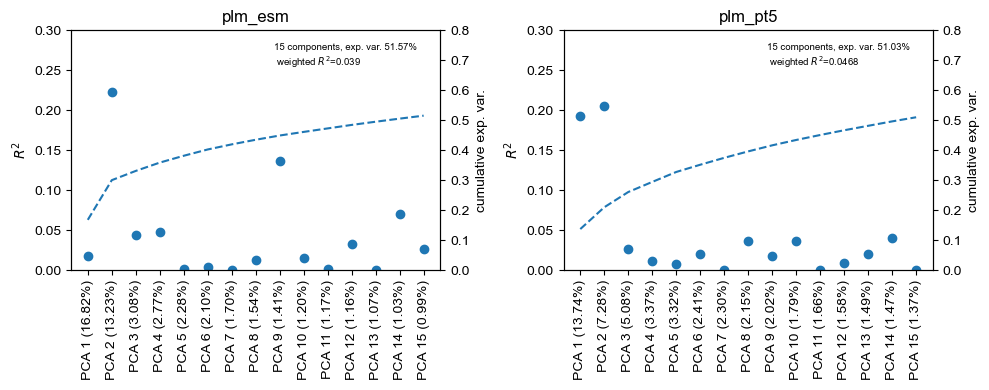

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

label = 'inter'
n_comps = 15 
plot_n_comps = 15

# for ax, feature_type in zip(axes, ['plm_esm', 'plm_pt5']):
for ax, feature_type in zip(axes, ['plm_esm', 'plm_pt5']):

    emb_df, seqs = load_embeddings(label, feature_type=feature_type)
    lengths = np.array([len(seq) for seq in seqs])

    emb, index = emb_df.values, emb_df.index

    scaler = StandardScaler()
    emb = scaler.fit_transform(emb)
    pca = PCA(n_components=n_comps)
    comps = pca.fit_transform(emb)

    exp_vars = pca.explained_variance_ratio_
    # print(f'Total explained variance: {100 * exp_var.sum():.2f}%')

    x_labels = []
    x = list(range(plot_n_comps))
    y1, y2 = list(), list()

    for i in range(n_comps):
        comp = comps[:, i].ravel()

        linreg = LinearRegression()
        linreg.fit(lengths.reshape(-1, 1), comp)
        r2 = linreg.score(lengths.reshape(-1, 1), comp)
        x_labels.append(f'PCA {i + 1} ({100 * exp_vars[i]:.2f}%)')
        y1.append(r2)
        y2.append(exp_vars[:i + 1].sum())

    ax.scatter(x, y1[:plot_n_comps], c=color_map[label])
    ax.set_ylim(0, 0.3)
    ax.set_ylabel('$R^2$')
    right_ax = ax.twinx()
    right_ax.plot(x, y2[:plot_n_comps], c=color_map[label], linestyle='--')
    right_ax.set_ylim(0, 0.8)
    right_ax.set_ylabel('cumulative exp. var.')

    ax.set_xticks(x, labels=x_labels[:plot_n_comps], rotation=90)
    ax.set_title(feature_type)

    weighted_r2 = (np.array(y1) * exp_vars).sum()
    ax.text(0.55, 0.85, f'{n_comps} components, exp. var. {exp_vars.sum() * 100:.2f}%\n weighted $R^2$={np.round(weighted_r2, 4)}', fontsize='x-small', transform=ax.transAxes)


# ax.set_xlabel(f'PCA 1 ({100 * exp_var[0]:.2f}%)')
# ax.set_ylabel(f'PCA 2 ({100 * exp_var[1]:.2f}%)')

# colors = [color_map[label] if id_ in pred_df.index else 'white' for id_ in index]
# sizes = [len(seq) / 10 for seq in seqs]
# ax.scatter(comps[:, 0], comps[:, 1], edgecolors=color_map[label], linewidth=0.7, color=colors, sizes=sizes)
plt.tight_layout()
plt.show()

